# GIS and Machine Learning with Python

This workshop is designed to get you familiar with basic GIS and machine learning functionality with a python SW stack. 

By the end of these lessions, you should be able to:
 - Download, explore, and plot from spatial files
 - Do basic manipulations of spatial shapes
 - Perform basic spatial analyses
 - Combine results from a machine learning model with spatial data

This workshop will be done using Jupyter Notebooks and requires the following modules:
     - GIS Modules
            - Geopandas
            - Shapely
            - Pyproj
            - Fiona
            - Geopy
            - Proximity Hash
            - Geohash
            
     - General Purpose Modules
             - Pandas
             - Matplotlib
             - Numpy
             - Pylab
             - Time
             - Sys

In [125]:
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon
import shapely.geometry
import pyproj
from fiona.crs import from_string, to_string
from geopy.distance import distance, vincenty
from geopy.geocoders import Nominatim, GoogleV3
import proximityhash
import folium
from folium.plugins import HeatMap
# import _geohash

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import sys

# set optional visual parameters for pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt.rcParams['image.cmap'] = 'YlGn'


# set optional display parameters for pandas
pd.options.display.max_rows = 6

# Activate Geopy geocoder
geolocator = Nominatim()
geolocator2 = GoogleV3()

## Part 1 - Basic GIS

1.1 Geometry

Geography is underlaid by geometrical shapes. When working with the geo-tools, we'll be dealing with 3 main elements: points, lines, and polygons. In this first section, we'll practice creating, analyzing and manipulating these elements.

2D Points

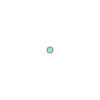

In [2]:

point1 = Point(1.2, 50) 
point2 = Point(5, -42.0)
point3 = Point(-6, 3.5)
point1

In [3]:
print(point1)

POINT (1.2 50)


In [4]:
# 2D Points have a few use methods and attributes including: coordinates, geom_type, distance
point1.x, point1.y, point1.coords.xy

(1.2, 50.0, (array('d', [1.2]), array('d', [50.0])))

In [5]:
# If you ever get confused about what a shapely object is, you can call "geom_type"
point1.geom_type

'Point'

In [6]:
# Given another point, the "distance" method an calclate the distance
point1.distance(point2)

92.078444817449

 LineStrings

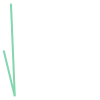

In [7]:

# We can create lines by entering coordinates, or by using points

line1 = LineString([point1, point2, point3])
line1



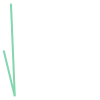

In [8]:
# I can enter the coordinate of our original points and get the same result

line2 = LineString([(1.2, 50), (5, -42.0), (-6, 3.5)])
line2

In [9]:
print(line1)

LINESTRING (1.2 50, 5 -42, -6 3.5)


In [10]:
line1.geom_type

'LineString'

In [11]:
# the 'centroid' method
print(line1.centroid)

POINT (1.886667356320875 -3.836106657094351)


In [12]:
# the "boundary" method
print(line1.boundary)

MULTIPOINT (1.2 50, -6 3.5)


In [13]:
# the 'length' attribute
line1.length

138.88923417204117

In [14]:
# We can also get the x & y coordinates of the line
line1.xy

(array('d', [1.2, 5.0, -6.0]), array('d', [50.0, -42.0, 3.5]))

Polygons

We can create polygons from points (by using their coordinates), or by inputing coordinates.

Using the previously generated points....

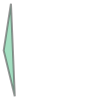

In [15]:
# Create polygon from coordinates

poly1 = Polygon([(1.2, 50), (5, -42.0), (-6, 3.5)])
poly1

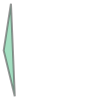

In [16]:
# Using something similar to a list comprehension, we can also generate the polygon using the coordinates of points

poly2 = Polygon([[point.x, point.y] for point in [point1, point2, point3]])
poly2

In [17]:
print(poly1)

POLYGON ((1.2 50, 5 -42, -6 3.5, 1.2 50))


Like maps objects, for instance continents with lakes or bodies of water with islands, polygons can have one or more holes inside of them.

In [18]:
larger_shape = [(-200, 100), (-200, -100), (200, -100), (200, 100)]
hole = [[(-150, 50), (-150, -50), (150, -50), (150, 50)]]
rect1 = Polygon(shell=larger_shape)
rect_with_hole = Polygon(shell=larger_shape, holes=hole)

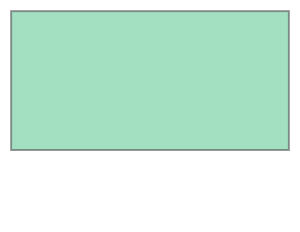

In [19]:
rect1

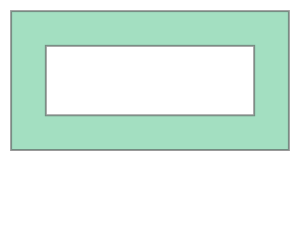

In [20]:
rect_with_hole

In [21]:
# Notice the printout of this shape has two sets of tuples in enclosed parentheses, one for the surrounding object, 
# and one for the hole

print(rect_with_hole)

POLYGON ((-200 100, -200 -100, 200 -100, 200 100, -200 100), (-150 50, -150 -50, 150 -50, 150 50, -150 50))


1.2 Downloading Shapefiles and Performing data exploration

GeoPandas allows import and inspection of geo-spatial files, such as shapefiles.

In this section, we'll download a file and do some basic inspection of it. Let's examine police precincts in Minneapolis.

I got the below file "Minneapolis_Police_Precincts.shp" from: http://opendata.minneapolismn.gov/datasets/minneapolis-police-precincts?geometry=-180%2C-88.438%2C180%2C88.438 . Many government agencies, from very the very local (school districts and townships) to the national and international (USA departments, UN agencies), make geospatial data available for free.

When downloading data, make sure you place all of the available files in one location. Even though below, we are loading only the .shp file, every file in its folder is needed for Geopandas to read it.


In [22]:
minne_police_precincts = gp.read_file('../data/Minneapolis_Police_Precincts.shp')

Coordinate Reference Systems: You MUST have the CRS of the geospatial data. When such data is published, it is expected that the CRS is included. But this is not guaranteed. If you don't have or can't find it, try contacting the agency that published the information. Or try to find the reference systems for maps published by agencies in the same region.

We can use the "crs" attribute to discover the CRS. But NOT ALL shapefiles contain this information.

Why is this information important? If you are going to do more than rudimentary manipulation of your data, a CRS could be crucial. Data that describes information in the same physical location may be published in different reference systems. One example I've found in my work:
    - Shapefiles describing the city boundaries
    - Locations of post addresses
    - Locations of crime events
In this example, all 3 instances of data were in a different CRS. Without normalizing this data to one system, doing analysis or basic plotting would be impossible.

In [23]:
minne_police_precincts.crs


{'init': 'epsg:4326'}

In [24]:
minne_police_precincts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
OBJECTID      5 non-null int64
PRECINCT      5 non-null object
Shape_STAr    5 non-null float64
Shape_STLe    5 non-null float64
geometry      5 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 280.0+ bytes


In [25]:
minne_police_precincts.describe()

OBJECTID    Shape_STAr     Shape_STLe
count  5.000000  5.000000e+00       5.000000
mean   3.000000  3.202794e+08   84753.135627
std    1.581139  1.371562e+08   21750.347715
...         ...           ...            ...
50%    3.000000  3.515368e+08   89658.738146
75%    4.000000  3.842519e+08   93920.868746
max    5.000000  4.616245e+08  103520.755021

[8 rows x 3 columns]

In [26]:
minne_police_precincts.head()

OBJECTID PRECINCT    Shape_STAr     Shape_STLe  \
0         1        1  9.659868e+07   47205.536504   
1         2        2  3.515368e+08   89459.779720   
2         3        3  4.616245e+08  103520.755021   
3         4        4  3.073853e+08   93920.868746   
4         5        5  3.842519e+08   89658.738146   

                                            geometry  
0  POLYGON ((-93.27211391203549 44.9921313598964,...  
1  POLYGON ((-93.22685080614011 45.0132165472863,...  
2  POLYGON ((-93.2504437423931 44.9663370085168, ...  
3  POLYGON ((-93.31949186501051 45.0512462469094,...  
4  POLYGON ((-93.287640885683 44.969659207443, -9...

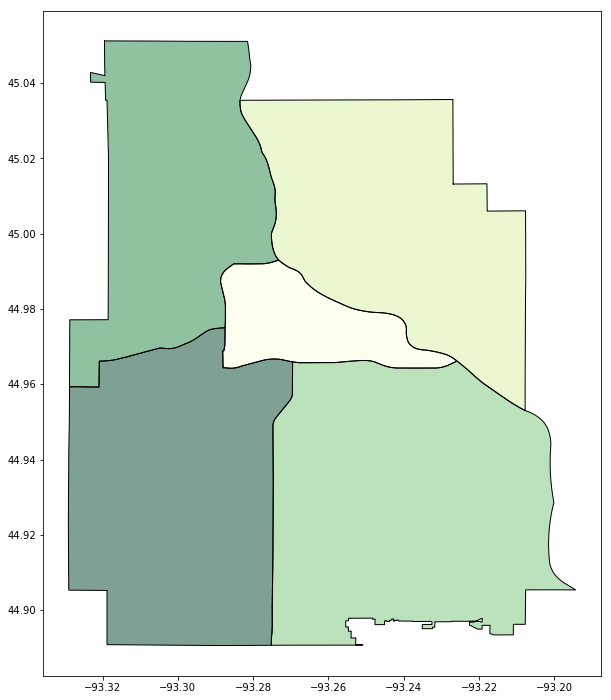

In [27]:
minne_police_precincts.plot()

Now that we have some basic boundaries of the city, let's annotate it a bit. First, let's find the location of this workshop, and place it on the map, with a label.

The address of the McNamara Alumni Center is  200 Oak St SE, Minneapolis, MN 55455.

We can find this location, with other data on google maps: https://www.google.com/maps/place/McNamara+Alumni+Center/@44.9750747,-93.2273836,15z/data=!4m5!3m4!1s0x0:0x5f984f594ceab6ad!8m2!3d44.9750747!4d-93.2273836

We can also notice latitude/longitude coordinates in the link of the location. However, what if we only had the address? How can we find the coordinates? This is where geocoding comes in. Geocoding tools convert postal addresses to geographical coordinates like latitude and longitude.

We are using the module geopy, and the Nominatum service to produce the coordinates. Nominatum (a service of the  OpenStreetMap Foundation) has a limit of one request per second, which is more than adequeate for our case. 

In [52]:
test_addrs = '200 Oak St SE, Minneapolis, MN 55455'
location = geolocator.geocode(test_addrs,timeout=10)

point_rhode = Point( location.longitude, location.latitude)
print(point_rhode)

AttributeError: 'NoneType' object has no attribute 'longitude'

What happened? No geocode service is perfect, and it seems that Nominatum cannot geocode the address for an unknown reason. Let's try Google Maps.

In [95]:
test_addrs2 = '200 Oak St SE, Minneapolis, MN 55455'
location2 = geolocator2.geocode(test_addrs2, timeout=10)

point_mac = Point( location2.longitude, location2.latitude)
print(point_mac)

POINT (-93.22760269999999 44.97538489999999)


In [86]:
test_addrs3 = '615 Washington Ave SE, Minneapolis, MN 55414'
location3 = geolocator2.geocode(test_addrs3, timeout=10)

point_grad = Point( location3.longitude, location3.latitude)
print(point_grad)

POINT (-93.2296097 44.9743662)


That seems to work. Below are items you can extract from the geocode object

In [88]:
print(location2.latitude, location2.longitude)
print('')
print(location2.raw)
print('')
print(location2.address)

44.97538489999999 -93.22760269999999

{'formatted_address': '200 SE Oak St, Minneapolis, MN 55455, USA', 'place_id': 'ChIJzSHy7hgts1IRiIsXrvGJMyw', 'partial_match': True, 'types': ['street_address'], 'address_components': [{'types': ['street_number'], 'long_name': '200', 'short_name': '200'}, {'types': ['route'], 'long_name': 'Southeast Oak Street', 'short_name': 'SE Oak St'}, {'types': ['neighborhood', 'political'], 'long_name': 'University of Minnesota - Twin Cities', 'short_name': 'University of Minnesota - Twin Cities'}, {'types': ['locality', 'political'], 'long_name': 'Minneapolis', 'short_name': 'Minneapolis'}, {'types': ['administrative_area_level_2', 'political'], 'long_name': 'Hennepin County', 'short_name': 'Hennepin County'}, {'types': ['administrative_area_level_1', 'political'], 'long_name': 'Minnesota', 'short_name': 'MN'}, {'types': ['country', 'political'], 'long_name': 'United States', 'short_name': 'US'}, {'types': ['postal_code'], 'long_name': '55455', 'short_name':

OK, so let's print this coordinate to our map

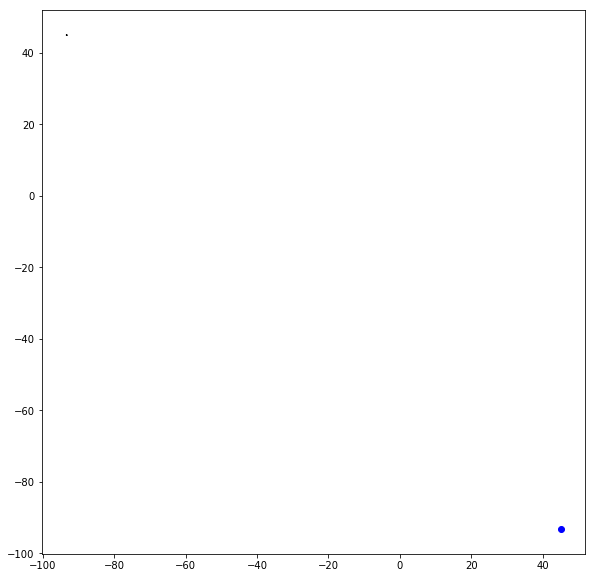

In [96]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
minne_police_precincts.plot( legend=True, ax=ax)
plt.plot(location2.latitude,location2.longitude,'bo')

This didn't work well because the location is not in a geopandas format and may not be in the same CRS. Let's transform this point now.

In [249]:
pt_mac = gp.GeoSeries([point_mac])
pt_mac.crs = {'init': 'epsg:4326', 'no_defs': True}
pt_mac

0    POINT (-93.22760269999999 44.97538489999999)
dtype: object

In [57]:
pt_grad = gp.GeoSeries([point_grad])
pt_grad.crs = {'init': 'epsg:4326', 'no_defs': True}
pt_grad

0    POINT (-93.22760269999999 44.97538489999999)
dtype: object

In [98]:
pt_mac[0].x, pt_mac[0].y

(-93.22760269999999, 44.97538489999999)

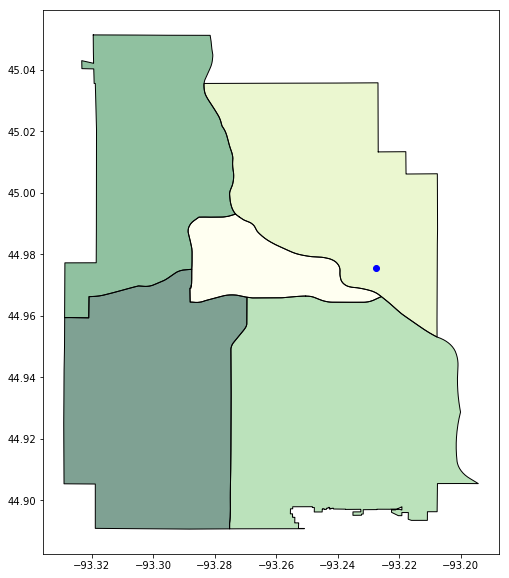

In [103]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
minne_police_precincts.plot( legend=True, ax=ax)
plt.plot(point_mac.x, point_mac.y,'bo')


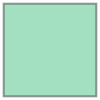

In [233]:
# - Draw bounding box

def bound_box_point_km(point, edge_length):
    
    lat = point.y
    lon = point.x
    
    min_lat = lat - (0.009 * edge_length)
    max_lat = lat + (0.009 * edge_length)
    min_lon = lon - (0.009 * edge_length)
    max_lon = lon + (0.009 * edge_length)
    
    point1 = Point(min_lon,min_lat)
    point2 = Point(max_lon,min_lat)
    point3 = Point(max_lon,max_lat)
    point4 = Point(min_lon,max_lat)

    bbox = Polygon([[point.x, point.y] for point in [point1, point2, point3, point4]])
    
    return bbox

bound_box_point_km(pt_mac[0], 10)



In [234]:
print(pt_mac, test_box)

0    POINT (-93.22760269999999 44.97538489999999)
dtype: object POLYGON ((44.88538489999998 -93.31760269999999, 44.88538489999998 -93.13760269999999, 45.06538489999999 -93.13760269999999, 45.06538489999999 -93.31760269999999, 44.88538489999998 -93.31760269999999))


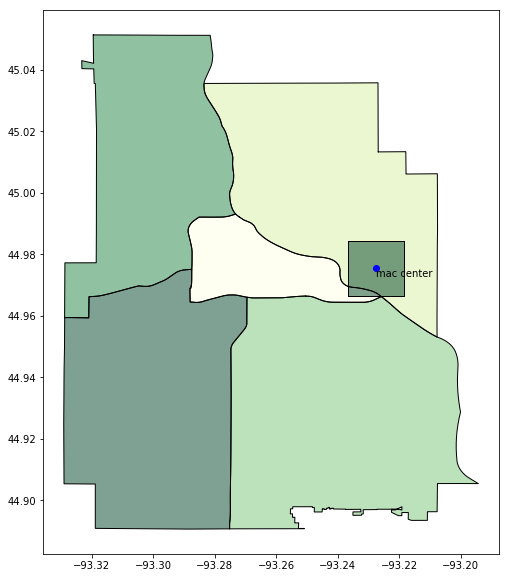

In [242]:
test_box = bound_box_point_km(pt_mac[0], 1)
tb = gp.GeoDataFrame()
tb['geometry'] = None
tb.loc[0, 'geometry'] = test_box

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
minne_police_precincts.plot( legend=True, ax=ax)
plt.plot(point_mac.x, point_mac.y,'bo')
tb.plot(ax=ax)
plt.annotate(s="mac center", xy=(point_mac.x, point_mac.y),
                 verticalalignment='top')
# tb.plot(ax=ax)

Now, let's take a list of police incidents from the same website and overlay them on the map

In [112]:
incidents = pd.read_csv('Police_Incidents_2013.csv')
incidents[['Lat','Long']]

Lat       Long
0      44.971890 -93.263530
1      44.894933 -93.278106
2      45.031510 -93.289370
...          ...        ...
21854  45.018580 -93.247270
21855  44.973924 -93.222418
21856  44.943948 -93.303983

[21857 rows x 2 columns]

In order work with these two pieces of data (the precinct boundaries and the police incidents), we have to have them both in GeoPandas format, and both in the same CRS.

In [248]:
# Put incidents in a GeoPandas dataframe
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(incidents.Long, incidents.Lat)]
stops = gp.GeoDataFrame(incidents, crs=crs, geometry=geometry)

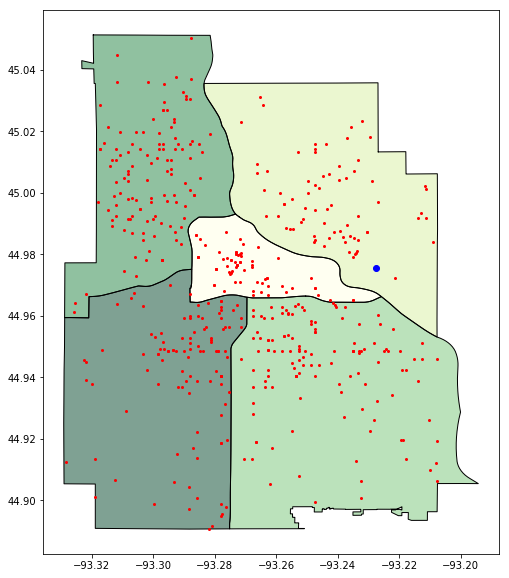

In [124]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
minne_police_precincts.plot( legend=True, ax=ax)
plt.plot(point_mac.x, point_mac.y,'bo')
stops.head(500).plot(color='red', ax=ax)

1.3 GeoHashing

"A geohash is a convenient way of expressing a location (anywhere in the world) using a short alphanumeric string, with greater precision obtained with longer strings."

Geohashes represent a global grid with precision chosen by the user.

In this notebook, we use the proximityhash module to generate geohash grids.


In [126]:
hash_list = proximityhash.create_geohash(44.98,-93.26, 20000, 6, georaptor_flag=False, minlevel=1, maxlevel=12).split(",")

In [127]:
len(hash_list)

2499

In [130]:
x_list = []
y_list = []
tp_geometry = gp.GeoSeries()
# tp_hash = gp.GeoSeries([None])
for hash in hash_list:
    bounding_box = bbox(hash)
    
    test_poly = Polygon([( bounding_box['e'],bounding_box['n']), ( bounding_box['e'],bounding_box['s']), ( bounding_box['w'],bounding_box['s'] ),( bounding_box['w'],bounding_box['n']) ])
    test_poly.crs = {'init': 'epsg:4326', 'no_defs': True}
    
    tp = gp.GeoSeries([test_poly])
    tp.crs = {'init': 'epsg:4326', 'no_defs': True}
    
    tp = tp.to_crs(crs=crs)
    print(tp[0])
    
    x,y = tp[0].exterior.xy
    
    x_list.append(x)
    y_list.append(y)
    
    tp_geometry = tp_geometry.append(tp)
    print(len(tp_geometry))

POLYGON ((-93.197021484375 45.0933837890625, -93.197021484375 45.087890625, -93.2080078125 45.087890625, -93.2080078125 45.0933837890625, -93.197021484375 45.0933837890625))
1
POLYGON ((-93.4716796875 44.88464355468751, -93.4716796875 44.879150390625, -93.482666015625 44.879150390625, -93.482666015625 44.88464355468751, -93.4716796875 44.88464355468751))
2
POLYGON ((-93.0322265625 45.00549316406251, -93.0322265625 45, -93.04321289062501 45, -93.04321289062501 45.00549316406251, -93.0322265625 45.00549316406251))
3
POLYGON ((-93.04321289062501 44.9505615234375, -93.04321289062501 44.945068359375, -93.05419921875 44.945068359375, -93.05419921875 44.9505615234375, -93.04321289062501 44.9505615234375))
4
POLYGON ((-93.1640625 44.989013671875, -93.1640625 44.9835205078125, -93.175048828125 44.9835205078125, -93.175048828125 44.989013671875, -93.1640625 44.989013671875))
5
POLYGON ((-93.438720703125 45.0604248046875, -93.438720703125 45.054931640625, -93.44970703125 45.054931640625, -93.4497

POLYGON ((-93.218994140625 45, -93.218994140625 44.9945068359375, -93.22998046875 44.9945068359375, -93.22998046875 45, -93.218994140625 45))
50
POLYGON ((-93.1640625 44.89013671875, -93.1640625 44.88464355468751, -93.175048828125 44.88464355468751, -93.175048828125 44.89013671875, -93.1640625 44.89013671875))
51
POLYGON ((-93.31787109375 44.8681640625, -93.31787109375 44.8626708984375, -93.328857421875 44.8626708984375, -93.328857421875 44.8681640625, -93.31787109375 44.8681640625))
52
POLYGON ((-93.328857421875 44.912109375, -93.328857421875 44.9066162109375, -93.33984375000001 44.9066162109375, -93.33984375000001 44.912109375, -93.328857421875 44.912109375))
53
POLYGON ((-93.2080078125 45.10986328125, -93.2080078125 45.1043701171875, -93.218994140625 45.1043701171875, -93.218994140625 45.10986328125, -93.2080078125 45.10986328125))
54
POLYGON ((-93.076171875 44.912109375, -93.076171875 44.9066162109375, -93.087158203125 44.9066162109375, -93.087158203125 44.912109375, -93.076171875 

POLYGON ((-93.416748046875 44.89013671875, -93.416748046875 44.88464355468751, -93.427734375 44.88464355468751, -93.427734375 44.89013671875, -93.416748046875 44.89013671875))
103
POLYGON ((-93.40576171875 45.1043701171875, -93.40576171875 45.09887695312501, -93.416748046875 45.09887695312501, -93.416748046875 45.1043701171875, -93.40576171875 45.1043701171875))
104
POLYGON ((-93.427734375 44.9945068359375, -93.427734375 44.989013671875, -93.438720703125 44.989013671875, -93.438720703125 44.9945068359375, -93.427734375 44.9945068359375))
105
POLYGON ((-93.394775390625 45.02197265625, -93.394775390625 45.0164794921875, -93.40576171875 45.0164794921875, -93.40576171875 45.02197265625, -93.394775390625 45.02197265625))
106
POLYGON ((-93.240966796875 44.88464355468751, -93.240966796875 44.879150390625, -93.251953125 44.879150390625, -93.251953125 44.88464355468751, -93.240966796875 44.88464355468751))
107
POLYGON ((-93.328857421875 45.0604248046875, -93.328857421875 45.054931640625, -93.33

POLYGON ((-93.22998046875 44.97802734375001, -93.22998046875 44.9725341796875, -93.240966796875 44.9725341796875, -93.240966796875 44.97802734375001, -93.22998046875 44.97802734375001))
157
POLYGON ((-93.240966796875 45.1483154296875, -93.240966796875 45.142822265625, -93.251953125 45.142822265625, -93.251953125 45.1483154296875, -93.240966796875 45.1483154296875))
158
POLYGON ((-93.109130859375 45.120849609375, -93.109130859375 45.1153564453125, -93.1201171875 45.1153564453125, -93.1201171875 45.120849609375, -93.109130859375 45.120849609375))
159
POLYGON ((-93.18603515625 44.923095703125, -93.18603515625 44.9176025390625, -93.197021484375 44.9176025390625, -93.197021484375 44.923095703125, -93.18603515625 44.923095703125))
160
POLYGON ((-93.175048828125 44.813232421875, -93.175048828125 44.8077392578125, -93.18603515625 44.8077392578125, -93.18603515625 44.813232421875, -93.175048828125 44.813232421875))
161
POLYGON ((-93.427734375 45.0714111328125, -93.427734375 45.06591796875, -93.

213
POLYGON ((-92.999267578125 44.9835205078125, -92.999267578125 44.97802734375001, -93.01025390625 44.97802734375001, -93.01025390625 44.9835205078125, -92.999267578125 44.9835205078125))
214
POLYGON ((-93.460693359375 44.8736572265625, -93.460693359375 44.8681640625, -93.4716796875 44.8681640625, -93.4716796875 44.8736572265625, -93.460693359375 44.8736572265625))
215
POLYGON ((-93.3837890625 45.10986328125, -93.3837890625 45.1043701171875, -93.394775390625 45.1043701171875, -93.394775390625 45.10986328125, -93.3837890625 45.10986328125))
216
POLYGON ((-93.262939453125 44.89013671875, -93.262939453125 44.88464355468751, -93.27392578125 44.88464355468751, -93.27392578125 44.89013671875, -93.262939453125 44.89013671875))
217
POLYGON ((-93.4716796875 44.9285888671875, -93.4716796875 44.923095703125, -93.482666015625 44.923095703125, -93.482666015625 44.9285888671875, -93.4716796875 44.9285888671875))
218
POLYGON ((-93.153076171875 45.076904296875, -93.153076171875 45.0714111328125, -93

POLYGON ((-93.1201171875 45.0823974609375, -93.1201171875 45.076904296875, -93.131103515625 45.076904296875, -93.131103515625 45.0823974609375, -93.1201171875 45.0823974609375))
271
POLYGON ((-93.306884765625 45.087890625, -93.306884765625 45.0823974609375, -93.31787109375 45.0823974609375, -93.31787109375 45.087890625, -93.306884765625 45.087890625))
272
POLYGON ((-93.31787109375 44.9395751953125, -93.31787109375 44.93408203125, -93.328857421875 44.93408203125, -93.328857421875 44.9395751953125, -93.31787109375 44.9395751953125))
273
POLYGON ((-93.394775390625 44.9066162109375, -93.394775390625 44.901123046875, -93.40576171875 44.901123046875, -93.40576171875 44.9066162109375, -93.394775390625 44.9066162109375))
274
POLYGON ((-93.438720703125 45.06591796875, -93.438720703125 45.0604248046875, -93.44970703125 45.0604248046875, -93.44970703125 45.06591796875, -93.438720703125 45.06591796875))
275
POLYGON ((-93.09814453125001 44.9945068359375, -93.09814453125001 44.989013671875, -93.1091

327
POLYGON ((-93.09814453125001 44.912109375, -93.09814453125001 44.9066162109375, -93.109130859375 44.9066162109375, -93.109130859375 44.912109375, -93.09814453125001 44.912109375))
328
POLYGON ((-93.1640625 44.8626708984375, -93.1640625 44.85717773437501, -93.175048828125 44.85717773437501, -93.175048828125 44.8626708984375, -93.1640625 44.8626708984375))
329
POLYGON ((-93.350830078125 45.09887695312501, -93.350830078125 45.0933837890625, -93.36181640625 45.0933837890625, -93.36181640625 45.09887695312501, -93.350830078125 45.09887695312501))
330
POLYGON ((-93.22998046875 44.967041015625, -93.22998046875 44.9615478515625, -93.240966796875 44.9615478515625, -93.240966796875 44.967041015625, -93.22998046875 44.967041015625))
331
POLYGON ((-93.416748046875 44.9560546875, -93.416748046875 44.9505615234375, -93.427734375 44.9505615234375, -93.427734375 44.9560546875, -93.416748046875 44.9560546875))
332
POLYGON ((-93.175048828125 45.09887695312501, -93.175048828125 45.0933837890625, -93.

POLYGON ((-93.2958984375 45.0164794921875, -93.2958984375 45.010986328125, -93.306884765625 45.010986328125, -93.306884765625 45.0164794921875, -93.2958984375 45.0164794921875))
382
POLYGON ((-93.1201171875 45, -93.1201171875 44.9945068359375, -93.131103515625 44.9945068359375, -93.131103515625 45, -93.1201171875 45))
383
POLYGON ((-93.218994140625 45.15380859375, -93.218994140625 45.1483154296875, -93.22998046875 45.1483154296875, -93.22998046875 45.15380859375, -93.218994140625 45.15380859375))
384
POLYGON ((-93.460693359375 45.0274658203125, -93.460693359375 45.02197265625, -93.4716796875 45.02197265625, -93.4716796875 45.0274658203125, -93.460693359375 45.0274658203125))
385
POLYGON ((-93.153076171875 45.0439453125, -93.153076171875 45.0384521484375, -93.1640625 45.0384521484375, -93.1640625 45.0439453125, -93.153076171875 45.0439453125))
386
POLYGON ((-93.482666015625 45.0439453125, -93.482666015625 45.0384521484375, -93.49365234375 45.0384521484375, -93.49365234375 45.0439453125,

POLYGON ((-93.1640625 45.0604248046875, -93.1640625 45.054931640625, -93.175048828125 45.054931640625, -93.175048828125 45.0604248046875, -93.1640625 45.0604248046875))
438
POLYGON ((-93.240966796875 45.142822265625, -93.240966796875 45.1373291015625, -93.251953125 45.1373291015625, -93.251953125 45.142822265625, -93.240966796875 45.142822265625))
439
POLYGON ((-93.427734375 44.901123046875, -93.427734375 44.8956298828125, -93.438720703125 44.8956298828125, -93.438720703125 44.901123046875, -93.427734375 44.901123046875))
440
POLYGON ((-93.2080078125 44.8681640625, -93.2080078125 44.8626708984375, -93.218994140625 44.8626708984375, -93.218994140625 44.8681640625, -93.2080078125 44.8681640625))
441
POLYGON ((-93.240966796875 45.032958984375, -93.240966796875 45.0274658203125, -93.251953125 45.0274658203125, -93.251953125 45.032958984375, -93.240966796875 45.032958984375))
442
POLYGON ((-93.33984375000001 44.8956298828125, -93.33984375000001 44.89013671875, -93.350830078125 44.8901367187

POLYGON ((-93.09814453125001 45.076904296875, -93.09814453125001 45.0714111328125, -93.109130859375 45.0714111328125, -93.109130859375 45.076904296875, -93.09814453125001 45.076904296875))
494
POLYGON ((-93.350830078125 44.9395751953125, -93.350830078125 44.93408203125, -93.36181640625 44.93408203125, -93.36181640625 44.9395751953125, -93.350830078125 44.9395751953125))
495
POLYGON ((-93.306884765625 45.00549316406251, -93.306884765625 45, -93.31787109375 45, -93.31787109375 45.00549316406251, -93.306884765625 45.00549316406251))
496
POLYGON ((-93.460693359375 44.923095703125, -93.460693359375 44.9176025390625, -93.4716796875 44.9176025390625, -93.4716796875 44.923095703125, -93.460693359375 44.923095703125))
497
POLYGON ((-93.04321289062501 45.00549316406251, -93.04321289062501 45, -93.05419921875 45, -93.05419921875 45.00549316406251, -93.04321289062501 45.00549316406251))
498
POLYGON ((-93.131103515625 44.9285888671875, -93.131103515625 44.923095703125, -93.14208984375 44.9230957031

POLYGON ((-93.372802734375 45.0823974609375, -93.372802734375 45.076904296875, -93.3837890625 45.076904296875, -93.3837890625 45.0823974609375, -93.372802734375 45.0823974609375))
544
POLYGON ((-93.27392578125 45.0494384765625, -93.27392578125 45.0439453125, -93.28491210937501 45.0439453125, -93.28491210937501 45.0494384765625, -93.27392578125 45.0494384765625))
545
POLYGON ((-93.262939453125 44.9066162109375, -93.262939453125 44.901123046875, -93.27392578125 44.901123046875, -93.27392578125 44.9066162109375, -93.262939453125 44.9066162109375))
546
POLYGON ((-93.05419921875 45.087890625, -93.05419921875 45.0823974609375, -93.065185546875 45.0823974609375, -93.065185546875 45.087890625, -93.05419921875 45.087890625))
547
POLYGON ((-93.328857421875 44.8516845703125, -93.328857421875 44.84619140625, -93.33984375000001 44.84619140625, -93.33984375000001 44.8516845703125, -93.328857421875 44.8516845703125))
548
POLYGON ((-92.999267578125 44.97802734375001, -92.999267578125 44.9725341796875,

594
POLYGON ((-93.251953125 45.0439453125, -93.251953125 45.0384521484375, -93.262939453125 45.0384521484375, -93.262939453125 45.0439453125, -93.251953125 45.0439453125))
595
POLYGON ((-93.076171875 45.10986328125, -93.076171875 45.1043701171875, -93.087158203125 45.1043701171875, -93.087158203125 45.10986328125, -93.076171875 45.10986328125))
596
POLYGON ((-93.262939453125 45.1043701171875, -93.262939453125 45.09887695312501, -93.27392578125 45.09887695312501, -93.27392578125 45.1043701171875, -93.262939453125 45.1043701171875))
597
POLYGON ((-93.394775390625 44.8406982421875, -93.394775390625 44.835205078125, -93.40576171875 44.835205078125, -93.40576171875 44.8406982421875, -93.394775390625 44.8406982421875))
598
POLYGON ((-93.36181640625 45.1373291015625, -93.36181640625 45.1318359375, -93.372802734375 45.1318359375, -93.372802734375 45.1373291015625, -93.36181640625 45.1373291015625))
599
POLYGON ((-93.2958984375 44.989013671875, -93.2958984375 44.9835205078125, -93.306884765625 

646
POLYGON ((-93.0322265625 44.9615478515625, -93.0322265625 44.9560546875, -93.04321289062501 44.9560546875, -93.04321289062501 44.9615478515625, -93.0322265625 44.9615478515625))
647
POLYGON ((-93.306884765625 44.8077392578125, -93.306884765625 44.80224609375, -93.31787109375 44.80224609375, -93.31787109375 44.8077392578125, -93.306884765625 44.8077392578125))
648
POLYGON ((-93.3837890625 45.1263427734375, -93.3837890625 45.120849609375, -93.394775390625 45.120849609375, -93.394775390625 45.1263427734375, -93.3837890625 45.1263427734375))
649
POLYGON ((-93.372802734375 45.10986328125, -93.372802734375 45.1043701171875, -93.3837890625 45.1043701171875, -93.3837890625 45.10986328125, -93.372802734375 45.10986328125))
650
POLYGON ((-93.251953125 44.88464355468751, -93.251953125 44.879150390625, -93.262939453125 44.879150390625, -93.262939453125 44.88464355468751, -93.251953125 44.88464355468751))
651
POLYGON ((-93.2958984375 44.923095703125, -93.2958984375 44.9176025390625, -93.3068847

700
POLYGON ((-93.04321289062501 44.9176025390625, -93.04321289062501 44.912109375, -93.05419921875 44.912109375, -93.05419921875 44.9176025390625, -93.04321289062501 44.9176025390625))
701
POLYGON ((-93.427734375 45.00549316406251, -93.427734375 45, -93.438720703125 45, -93.438720703125 45.00549316406251, -93.427734375 45.00549316406251))
702
POLYGON ((-93.2958984375 44.8187255859375, -93.2958984375 44.813232421875, -93.306884765625 44.813232421875, -93.306884765625 44.8187255859375, -93.2958984375 44.8187255859375))
703
POLYGON ((-93.14208984375 45.120849609375, -93.14208984375 45.1153564453125, -93.153076171875 45.1153564453125, -93.153076171875 45.120849609375, -93.14208984375 45.120849609375))
704
POLYGON ((-93.087158203125 44.9285888671875, -93.087158203125 44.923095703125, -93.09814453125001 44.923095703125, -93.09814453125001 44.9285888671875, -93.087158203125 44.9285888671875))
705
POLYGON ((-93.4716796875 45.0494384765625, -93.4716796875 45.0439453125, -93.482666015625 45.043

POLYGON ((-93.36181640625 44.879150390625, -93.36181640625 44.8736572265625, -93.372802734375 44.8736572265625, -93.372802734375 44.879150390625, -93.36181640625 44.879150390625))
758
POLYGON ((-93.2080078125 44.8626708984375, -93.2080078125 44.85717773437501, -93.218994140625 44.85717773437501, -93.218994140625 44.8626708984375, -93.2080078125 44.8626708984375))
759
POLYGON ((-93.18603515625 45.010986328125, -93.18603515625 45.00549316406251, -93.197021484375 45.00549316406251, -93.197021484375 45.010986328125, -93.18603515625 45.010986328125))
760
POLYGON ((-93.416748046875 45.06591796875, -93.416748046875 45.0604248046875, -93.427734375 45.0604248046875, -93.427734375 45.06591796875, -93.416748046875 45.06591796875))
761
POLYGON ((-93.44970703125 45.06591796875, -93.44970703125 45.0604248046875, -93.460693359375 45.0604248046875, -93.460693359375 45.06591796875, -93.44970703125 45.06591796875))
762
POLYGON ((-93.09814453125001 45.010986328125, -93.09814453125001 45.00549316406251, -

POLYGON ((-93.33984375000001 44.8681640625, -93.33984375000001 44.8626708984375, -93.350830078125 44.8626708984375, -93.350830078125 44.8681640625, -93.33984375000001 44.8681640625))
809
POLYGON ((-93.36181640625 44.901123046875, -93.36181640625 44.8956298828125, -93.372802734375 44.8956298828125, -93.372802734375 44.901123046875, -93.36181640625 44.901123046875))
810
POLYGON ((-93.197021484375 45.0164794921875, -93.197021484375 45.010986328125, -93.2080078125 45.010986328125, -93.2080078125 45.0164794921875, -93.197021484375 45.0164794921875))
811
POLYGON ((-93.4716796875 44.93408203125, -93.4716796875 44.9285888671875, -93.482666015625 44.9285888671875, -93.482666015625 44.93408203125, -93.4716796875 44.93408203125))
812
POLYGON ((-93.31787109375 45.1153564453125, -93.31787109375 45.10986328125, -93.328857421875 45.10986328125, -93.328857421875 45.1153564453125, -93.31787109375 45.1153564453125))
813
POLYGON ((-93.240966796875 45.0274658203125, -93.240966796875 45.02197265625, -93.25

871
POLYGON ((-93.262939453125 45.032958984375, -93.262939453125 45.0274658203125, -93.27392578125 45.0274658203125, -93.27392578125 45.032958984375, -93.262939453125 45.032958984375))
872
POLYGON ((-93.1201171875 45.00549316406251, -93.1201171875 45, -93.131103515625 45, -93.131103515625 45.00549316406251, -93.1201171875 45.00549316406251))
873
POLYGON ((-93.1640625 45.0384521484375, -93.1640625 45.032958984375, -93.175048828125 45.032958984375, -93.175048828125 45.0384521484375, -93.1640625 45.0384521484375))
874
POLYGON ((-93.0322265625 45.0714111328125, -93.0322265625 45.06591796875, -93.04321289062501 45.06591796875, -93.04321289062501 45.0714111328125, -93.0322265625 45.0714111328125))
875
POLYGON ((-93.197021484375 44.89013671875, -93.197021484375 44.88464355468751, -93.2080078125 44.88464355468751, -93.2080078125 44.89013671875, -93.197021484375 44.89013671875))
876
POLYGON ((-93.438720703125 45.09887695312501, -93.438720703125 45.0933837890625, -93.44970703125 45.0933837890625

POLYGON ((-93.109130859375 44.97802734375001, -93.109130859375 44.9725341796875, -93.1201171875 44.9725341796875, -93.1201171875 44.97802734375001, -93.109130859375 44.97802734375001))
923
POLYGON ((-93.18603515625 44.989013671875, -93.18603515625 44.9835205078125, -93.197021484375 44.9835205078125, -93.197021484375 44.989013671875, -93.18603515625 44.989013671875))
924
POLYGON ((-93.175048828125 44.8297119140625, -93.175048828125 44.82421875, -93.18603515625 44.82421875, -93.18603515625 44.8297119140625, -93.175048828125 44.8297119140625))
925
POLYGON ((-93.350830078125 45.1483154296875, -93.350830078125 45.142822265625, -93.36181640625 45.142822265625, -93.36181640625 45.1483154296875, -93.350830078125 45.1483154296875))
926
POLYGON ((-93.33984375000001 45.1043701171875, -93.33984375000001 45.09887695312501, -93.350830078125 45.09887695312501, -93.350830078125 45.1043701171875, -93.33984375000001 45.1043701171875))
927
POLYGON ((-93.416748046875 44.9945068359375, -93.416748046875 44.

POLYGON ((-93.1640625 44.97802734375001, -93.1640625 44.9725341796875, -93.175048828125 44.9725341796875, -93.175048828125 44.97802734375001, -93.1640625 44.97802734375001))
971
POLYGON ((-93.131103515625 44.967041015625, -93.131103515625 44.9615478515625, -93.14208984375 44.9615478515625, -93.14208984375 44.967041015625, -93.131103515625 44.967041015625))
972
POLYGON ((-93.36181640625 45.0604248046875, -93.36181640625 45.054931640625, -93.372802734375 45.054931640625, -93.372802734375 45.0604248046875, -93.36181640625 45.0604248046875))
973
POLYGON ((-93.131103515625 44.97802734375001, -93.131103515625 44.9725341796875, -93.14208984375 44.9725341796875, -93.14208984375 44.97802734375001, -93.131103515625 44.97802734375001))
974
POLYGON ((-93.076171875 44.9560546875, -93.076171875 44.9505615234375, -93.087158203125 44.9505615234375, -93.087158203125 44.9560546875, -93.076171875 44.9560546875))
975
POLYGON ((-93.36181640625 44.9835205078125, -93.36181640625 44.97802734375001, -93.372802

POLYGON ((-93.1640625 44.945068359375, -93.1640625 44.9395751953125, -93.175048828125 44.9395751953125, -93.175048828125 44.945068359375, -93.1640625 44.945068359375))
1021
POLYGON ((-93.22998046875 45.1483154296875, -93.22998046875 45.142822265625, -93.240966796875 45.142822265625, -93.240966796875 45.1483154296875, -93.22998046875 45.1483154296875))
1022
POLYGON ((-93.22998046875 45.032958984375, -93.22998046875 45.0274658203125, -93.240966796875 45.0274658203125, -93.240966796875 45.032958984375, -93.22998046875 45.032958984375))
1023
POLYGON ((-93.09814453125001 45.06591796875, -93.09814453125001 45.0604248046875, -93.109130859375 45.0604248046875, -93.109130859375 45.06591796875, -93.09814453125001 45.06591796875))
1024
POLYGON ((-93.306884765625 44.8516845703125, -93.306884765625 44.84619140625, -93.31787109375 44.84619140625, -93.31787109375 44.8516845703125, -93.306884765625 44.8516845703125))
1025
POLYGON ((-93.04321289062501 45.076904296875, -93.04321289062501 45.071411132812

POLYGON ((-93.218994140625 45.1483154296875, -93.218994140625 45.142822265625, -93.22998046875 45.142822265625, -93.22998046875 45.1483154296875, -93.218994140625 45.1483154296875))
1078
POLYGON ((-93.04321289062501 44.9395751953125, -93.04321289062501 44.93408203125, -93.05419921875 44.93408203125, -93.05419921875 44.9395751953125, -93.04321289062501 44.9395751953125))
1079
POLYGON ((-93.3837890625 44.85717773437501, -93.3837890625 44.8516845703125, -93.394775390625 44.8516845703125, -93.394775390625 44.85717773437501, -93.3837890625 44.85717773437501))
1080
POLYGON ((-93.31787109375 45.0164794921875, -93.31787109375 45.010986328125, -93.328857421875 45.010986328125, -93.328857421875 45.0164794921875, -93.31787109375 45.0164794921875))
1081
POLYGON ((-93.36181640625 45.1263427734375, -93.36181640625 45.120849609375, -93.372802734375 45.120849609375, -93.372802734375 45.1263427734375, -93.36181640625 45.1263427734375))
1082
POLYGON ((-93.3837890625 44.97802734375001, -93.3837890625 44.

POLYGON ((-93.2080078125 45.02197265625, -93.2080078125 45.0164794921875, -93.218994140625 45.0164794921875, -93.218994140625 45.02197265625, -93.2080078125 45.02197265625))
1133
POLYGON ((-93.28491210937501 44.9285888671875, -93.28491210937501 44.923095703125, -93.2958984375 44.923095703125, -93.2958984375 44.9285888671875, -93.28491210937501 44.9285888671875))
1134
POLYGON ((-93.460693359375 44.879150390625, -93.460693359375 44.8736572265625, -93.4716796875 44.8736572265625, -93.4716796875 44.879150390625, -93.460693359375 44.879150390625))
1135
POLYGON ((-93.2080078125 45.09887695312501, -93.2080078125 45.0933837890625, -93.218994140625 45.0933837890625, -93.218994140625 45.09887695312501, -93.2080078125 45.09887695312501))
1136
POLYGON ((-93.416748046875 44.8516845703125, -93.416748046875 44.84619140625, -93.427734375 44.84619140625, -93.427734375 44.8516845703125, -93.416748046875 44.8516845703125))
1137
POLYGON ((-93.22998046875 44.84619140625, -93.22998046875 44.8406982421875, -

POLYGON ((-93.087158203125 45.0823974609375, -93.087158203125 45.076904296875, -93.09814453125001 45.076904296875, -93.09814453125001 45.0823974609375, -93.087158203125 45.0823974609375))
1182
POLYGON ((-93.40576171875 44.967041015625, -93.40576171875 44.9615478515625, -93.416748046875 44.9615478515625, -93.416748046875 44.967041015625, -93.40576171875 44.967041015625))
1183
POLYGON ((-93.131103515625 45.1153564453125, -93.131103515625 45.10986328125, -93.14208984375 45.10986328125, -93.14208984375 45.1153564453125, -93.131103515625 45.1153564453125))
1184
POLYGON ((-93.482666015625 44.93408203125, -93.482666015625 44.9285888671875, -93.49365234375 44.9285888671875, -93.49365234375 44.93408203125, -93.482666015625 44.93408203125))
1185
POLYGON ((-93.2958984375 44.8626708984375, -93.2958984375 44.85717773437501, -93.306884765625 44.85717773437501, -93.306884765625 44.8626708984375, -93.2958984375 44.8626708984375))
1186
POLYGON ((-93.1201171875 45.02197265625, -93.1201171875 45.01647949

POLYGON ((-93.2958984375 44.8736572265625, -93.2958984375 44.8681640625, -93.306884765625 44.8681640625, -93.306884765625 44.8736572265625, -93.2958984375 44.8736572265625))
1233
POLYGON ((-93.49365234375 45.0494384765625, -93.49365234375 45.0439453125, -93.504638671875 45.0439453125, -93.504638671875 45.0494384765625, -93.49365234375 45.0494384765625))
1234
POLYGON ((-93.350830078125 45.0933837890625, -93.350830078125 45.087890625, -93.36181640625 45.087890625, -93.36181640625 45.0933837890625, -93.350830078125 45.0933837890625))
1235
POLYGON ((-93.306884765625 44.813232421875, -93.306884765625 44.8077392578125, -93.31787109375 44.8077392578125, -93.31787109375 44.813232421875, -93.306884765625 44.813232421875))
1236
POLYGON ((-93.218994140625 45.10986328125, -93.218994140625 45.1043701171875, -93.22998046875 45.1043701171875, -93.22998046875 45.10986328125, -93.218994140625 45.10986328125))
1237
POLYGON ((-93.2958984375 44.9505615234375, -93.2958984375 44.945068359375, -93.3068847656

POLYGON ((-93.33984375000001 44.9725341796875, -93.33984375000001 44.967041015625, -93.350830078125 44.967041015625, -93.350830078125 44.9725341796875, -93.33984375000001 44.9725341796875))
1286
POLYGON ((-93.3837890625 44.8681640625, -93.3837890625 44.8626708984375, -93.394775390625 44.8626708984375, -93.394775390625 44.8681640625, -93.3837890625 44.8681640625))
1287
POLYGON ((-93.087158203125 45.1153564453125, -93.087158203125 45.10986328125, -93.09814453125001 45.10986328125, -93.09814453125001 45.1153564453125, -93.087158203125 45.1153564453125))
1288
POLYGON ((-93.33984375000001 45.087890625, -93.33984375000001 45.0823974609375, -93.350830078125 45.0823974609375, -93.350830078125 45.087890625, -93.33984375000001 45.087890625))
1289
POLYGON ((-93.109130859375 45.076904296875, -93.109130859375 45.0714111328125, -93.1201171875 45.0714111328125, -93.1201171875 45.076904296875, -93.109130859375 45.076904296875))
1290
POLYGON ((-93.197021484375 45.032958984375, -93.197021484375 45.02746

POLYGON ((-93.01025390625 44.9945068359375, -93.01025390625 44.989013671875, -93.021240234375 44.989013671875, -93.021240234375 44.9945068359375, -93.01025390625 44.9945068359375))
1337
POLYGON ((-93.31787109375 45.120849609375, -93.31787109375 45.1153564453125, -93.328857421875 45.1153564453125, -93.328857421875 45.120849609375, -93.31787109375 45.120849609375))
1338
POLYGON ((-93.306884765625 44.9176025390625, -93.306884765625 44.912109375, -93.31787109375 44.912109375, -93.31787109375 44.9176025390625, -93.306884765625 44.9176025390625))
1339
POLYGON ((-93.087158203125 44.945068359375, -93.087158203125 44.9395751953125, -93.09814453125001 44.9395751953125, -93.09814453125001 44.945068359375, -93.087158203125 44.945068359375))
1340
POLYGON ((-93.36181640625 45.0439453125, -93.36181640625 45.0384521484375, -93.372802734375 45.0384521484375, -93.372802734375 45.0439453125, -93.36181640625 45.0439453125))
1341
POLYGON ((-93.153076171875 44.879150390625, -93.153076171875 44.8736572265625

POLYGON ((-93.175048828125 45.054931640625, -93.175048828125 45.0494384765625, -93.18603515625 45.0494384765625, -93.18603515625 45.054931640625, -93.175048828125 45.054931640625))
1387
POLYGON ((-93.328857421875 44.8297119140625, -93.328857421875 44.82421875, -93.33984375000001 44.82421875, -93.33984375000001 44.8297119140625, -93.328857421875 44.8297119140625))
1388
POLYGON ((-93.4716796875 44.9615478515625, -93.4716796875 44.9560546875, -93.482666015625 44.9560546875, -93.482666015625 44.9615478515625, -93.4716796875 44.9615478515625))
1389
POLYGON ((-93.087158203125 45.0274658203125, -93.087158203125 45.02197265625, -93.09814453125001 45.02197265625, -93.09814453125001 45.0274658203125, -93.087158203125 45.0274658203125))
1390
POLYGON ((-93.3837890625 45.1318359375, -93.3837890625 45.1263427734375, -93.394775390625 45.1263427734375, -93.394775390625 45.1318359375, -93.3837890625 45.1318359375))
1391
POLYGON ((-93.394775390625 44.967041015625, -93.394775390625 44.9615478515625, -93.

POLYGON ((-93.372802734375 45.09887695312501, -93.372802734375 45.0933837890625, -93.3837890625 45.0933837890625, -93.3837890625 45.09887695312501, -93.372802734375 45.09887695312501))
1441
POLYGON ((-93.3837890625 44.967041015625, -93.3837890625 44.9615478515625, -93.394775390625 44.9615478515625, -93.394775390625 44.967041015625, -93.3837890625 44.967041015625))
1442
POLYGON ((-93.131103515625 44.84619140625, -93.131103515625 44.8406982421875, -93.14208984375 44.8406982421875, -93.14208984375 44.84619140625, -93.131103515625 44.84619140625))
1443
POLYGON ((-93.18603515625 44.82421875, -93.18603515625 44.8187255859375, -93.197021484375 44.8187255859375, -93.197021484375 44.82421875, -93.18603515625 44.82421875))
1444
POLYGON ((-93.251953125 44.8626708984375, -93.251953125 44.85717773437501, -93.262939453125 44.85717773437501, -93.262939453125 44.8626708984375, -93.251953125 44.8626708984375))
1445
POLYGON ((-93.021240234375 45, -93.021240234375 44.9945068359375, -93.0322265625 44.9945

1497
POLYGON ((-93.49365234375 44.9505615234375, -93.49365234375 44.945068359375, -93.504638671875 44.945068359375, -93.504638671875 44.9505615234375, -93.49365234375 44.9505615234375))
1498
POLYGON ((-93.087158203125 45.0604248046875, -93.087158203125 45.054931640625, -93.09814453125001 45.054931640625, -93.09814453125001 45.0604248046875, -93.087158203125 45.0604248046875))
1499
POLYGON ((-93.350830078125 45.0274658203125, -93.350830078125 45.02197265625, -93.36181640625 45.02197265625, -93.36181640625 45.0274658203125, -93.350830078125 45.0274658203125))
1500
POLYGON ((-93.394775390625 45.0823974609375, -93.394775390625 45.076904296875, -93.40576171875 45.076904296875, -93.40576171875 45.0823974609375, -93.394775390625 45.0823974609375))
1501
POLYGON ((-93.153076171875 44.8297119140625, -93.153076171875 44.82421875, -93.1640625 44.82421875, -93.1640625 44.8297119140625, -93.153076171875 44.8297119140625))
1502
POLYGON ((-93.28491210937501 44.879150390625, -93.28491210937501 44.87365

POLYGON ((-93.416748046875 44.9285888671875, -93.416748046875 44.923095703125, -93.427734375 44.923095703125, -93.427734375 44.9285888671875, -93.416748046875 44.9285888671875))
1551
POLYGON ((-93.504638671875 44.967041015625, -93.504638671875 44.9615478515625, -93.515625 44.9615478515625, -93.515625 44.967041015625, -93.504638671875 44.967041015625))
1552
POLYGON ((-93.2958984375 44.9285888671875, -93.2958984375 44.923095703125, -93.306884765625 44.923095703125, -93.306884765625 44.9285888671875, -93.2958984375 44.9285888671875))
1553
POLYGON ((-93.504638671875 44.9945068359375, -93.504638671875 44.989013671875, -93.515625 44.989013671875, -93.515625 44.9945068359375, -93.504638671875 44.9945068359375))
1554
POLYGON ((-93.44970703125 44.9395751953125, -93.44970703125 44.93408203125, -93.460693359375 44.93408203125, -93.460693359375 44.9395751953125, -93.44970703125 44.9395751953125))
1555
POLYGON ((-93.460693359375 45, -93.460693359375 44.9945068359375, -93.4716796875 44.9945068359375

POLYGON ((-93.44970703125 45.0164794921875, -93.44970703125 45.010986328125, -93.460693359375 45.010986328125, -93.460693359375 45.0164794921875, -93.44970703125 45.0164794921875))
1607
POLYGON ((-93.076171875 45.0714111328125, -93.076171875 45.06591796875, -93.087158203125 45.06591796875, -93.087158203125 45.0714111328125, -93.076171875 45.0714111328125))
1608
POLYGON ((-93.2958984375 44.88464355468751, -93.2958984375 44.879150390625, -93.306884765625 44.879150390625, -93.306884765625 44.88464355468751, -93.2958984375 44.88464355468751))
1609
POLYGON ((-93.372802734375 45.1263427734375, -93.372802734375 45.120849609375, -93.3837890625 45.120849609375, -93.3837890625 45.1263427734375, -93.372802734375 45.1263427734375))
1610
POLYGON ((-93.01025390625 44.9395751953125, -93.01025390625 44.93408203125, -93.021240234375 44.93408203125, -93.021240234375 44.9395751953125, -93.01025390625 44.9395751953125))
1611
POLYGON ((-93.1201171875 45.1318359375, -93.1201171875 45.1263427734375, -93.1311

1661
POLYGON ((-93.153076171875 45.06591796875, -93.153076171875 45.0604248046875, -93.1640625 45.0604248046875, -93.1640625 45.06591796875, -93.153076171875 45.06591796875))
1662
POLYGON ((-93.1201171875 44.879150390625, -93.1201171875 44.8736572265625, -93.131103515625 44.8736572265625, -93.131103515625 44.879150390625, -93.1201171875 44.879150390625))
1663
POLYGON ((-93.240966796875 44.97802734375001, -93.240966796875 44.9725341796875, -93.251953125 44.9725341796875, -93.251953125 44.97802734375001, -93.240966796875 44.97802734375001))
1664
POLYGON ((-93.3837890625 44.9615478515625, -93.3837890625 44.9560546875, -93.394775390625 44.9560546875, -93.394775390625 44.9615478515625, -93.3837890625 44.9615478515625))
1665
POLYGON ((-93.197021484375 45.076904296875, -93.197021484375 45.0714111328125, -93.2080078125 45.0714111328125, -93.2080078125 45.076904296875, -93.197021484375 45.076904296875))
1666
POLYGON ((-93.40576171875 44.9560546875, -93.40576171875 44.9505615234375, -93.41674804

POLYGON ((-93.306884765625 44.879150390625, -93.306884765625 44.8736572265625, -93.31787109375 44.8736572265625, -93.31787109375 44.879150390625, -93.306884765625 44.879150390625))
1715
POLYGON ((-93.131103515625 44.8297119140625, -93.131103515625 44.82421875, -93.14208984375 44.82421875, -93.14208984375 44.8297119140625, -93.131103515625 44.8297119140625))
1716
POLYGON ((-93.22998046875 44.9285888671875, -93.22998046875 44.923095703125, -93.240966796875 44.923095703125, -93.240966796875 44.9285888671875, -93.22998046875 44.9285888671875))
1717
POLYGON ((-93.065185546875 44.9176025390625, -93.065185546875 44.912109375, -93.076171875 44.912109375, -93.076171875 44.9176025390625, -93.065185546875 44.9176025390625))
1718
POLYGON ((-93.328857421875 45.076904296875, -93.328857421875 45.0714111328125, -93.33984375000001 45.0714111328125, -93.33984375000001 45.076904296875, -93.328857421875 45.076904296875))
1719
POLYGON ((-93.2958984375 44.9560546875, -93.2958984375 44.9505615234375, -93.306

1767
POLYGON ((-93.09814453125001 44.9560546875, -93.09814453125001 44.9505615234375, -93.109130859375 44.9505615234375, -93.109130859375 44.9560546875, -93.09814453125001 44.9560546875))
1768
POLYGON ((-93.197021484375 45.1153564453125, -93.197021484375 45.10986328125, -93.2080078125 45.10986328125, -93.2080078125 45.1153564453125, -93.197021484375 45.1153564453125))
1769
POLYGON ((-93.394775390625 44.8516845703125, -93.394775390625 44.84619140625, -93.40576171875 44.84619140625, -93.40576171875 44.8516845703125, -93.394775390625 44.8516845703125))
1770
POLYGON ((-93.350830078125 44.835205078125, -93.350830078125 44.8297119140625, -93.36181640625 44.8297119140625, -93.36181640625 44.835205078125, -93.350830078125 44.835205078125))
1771
POLYGON ((-93.328857421875 44.9725341796875, -93.328857421875 44.967041015625, -93.33984375000001 44.967041015625, -93.33984375000001 44.9725341796875, -93.328857421875 44.9725341796875))
1772
POLYGON ((-93.460693359375 44.9066162109375, -93.46069335937

1813
POLYGON ((-93.2080078125 45.1483154296875, -93.2080078125 45.142822265625, -93.218994140625 45.142822265625, -93.218994140625 45.1483154296875, -93.2080078125 45.1483154296875))
1814
POLYGON ((-93.44970703125 45.032958984375, -93.44970703125 45.0274658203125, -93.460693359375 45.0274658203125, -93.460693359375 45.032958984375, -93.44970703125 45.032958984375))
1815
POLYGON ((-93.40576171875 44.89013671875, -93.40576171875 44.88464355468751, -93.416748046875 44.88464355468751, -93.416748046875 44.89013671875, -93.40576171875 44.89013671875))
1816
POLYGON ((-93.28491210937501 44.9066162109375, -93.28491210937501 44.901123046875, -93.2958984375 44.901123046875, -93.2958984375 44.9066162109375, -93.28491210937501 44.9066162109375))
1817
POLYGON ((-92.999267578125 44.9725341796875, -92.999267578125 44.967041015625, -93.01025390625 44.967041015625, -93.01025390625 44.9725341796875, -92.999267578125 44.9725341796875))
1818
POLYGON ((-93.328857421875 44.82421875, -93.328857421875 44.81872

1861
POLYGON ((-93.4716796875 45.0714111328125, -93.4716796875 45.06591796875, -93.482666015625 45.06591796875, -93.482666015625 45.0714111328125, -93.4716796875 45.0714111328125))
1862
POLYGON ((-93.28491210937501 44.8626708984375, -93.28491210937501 44.85717773437501, -93.2958984375 44.85717773437501, -93.2958984375 44.8626708984375, -93.28491210937501 44.8626708984375))
1863
POLYGON ((-93.2080078125 44.8406982421875, -93.2080078125 44.835205078125, -93.218994140625 44.835205078125, -93.218994140625 44.8406982421875, -93.2080078125 44.8406982421875))
1864
POLYGON ((-93.33984375000001 45.120849609375, -93.33984375000001 45.1153564453125, -93.350830078125 45.1153564453125, -93.350830078125 45.120849609375, -93.33984375000001 45.120849609375))
1865
POLYGON ((-93.153076171875 45.0823974609375, -93.153076171875 45.076904296875, -93.1640625 45.076904296875, -93.1640625 45.0823974609375, -93.153076171875 45.0823974609375))
1866
POLYGON ((-93.240966796875 45.0714111328125, -93.240966796875 4

POLYGON ((-93.427734375 44.8681640625, -93.427734375 44.8626708984375, -93.438720703125 44.8626708984375, -93.438720703125 44.8681640625, -93.427734375 44.8681640625))
1915
POLYGON ((-93.175048828125 44.8956298828125, -93.175048828125 44.89013671875, -93.18603515625 44.89013671875, -93.18603515625 44.8956298828125, -93.175048828125 44.8956298828125))
1916
POLYGON ((-93.240966796875 45.0439453125, -93.240966796875 45.0384521484375, -93.251953125 45.0384521484375, -93.251953125 45.0439453125, -93.240966796875 45.0439453125))
1917
POLYGON ((-93.1201171875 44.9835205078125, -93.1201171875 44.97802734375001, -93.131103515625 44.97802734375001, -93.131103515625 44.9835205078125, -93.1201171875 44.9835205078125))
1918
POLYGON ((-93.14208984375 44.9560546875, -93.14208984375 44.9505615234375, -93.153076171875 44.9505615234375, -93.153076171875 44.9560546875, -93.14208984375 44.9560546875))
1919
POLYGON ((-93.251953125 44.9615478515625, -93.251953125 44.9560546875, -93.262939453125 44.956054687

1992
POLYGON ((-93.28491210937501 44.901123046875, -93.28491210937501 44.8956298828125, -93.2958984375 44.8956298828125, -93.2958984375 44.901123046875, -93.28491210937501 44.901123046875))
1993
POLYGON ((-93.14208984375 44.88464355468751, -93.14208984375 44.879150390625, -93.153076171875 44.879150390625, -93.153076171875 44.88464355468751, -93.14208984375 44.88464355468751))
1994
POLYGON ((-93.197021484375 45, -93.197021484375 44.9945068359375, -93.2080078125 44.9945068359375, -93.2080078125 45, -93.197021484375 45))
1995
POLYGON ((-93.36181640625 44.89013671875, -93.36181640625 44.88464355468751, -93.372802734375 44.88464355468751, -93.372802734375 44.89013671875, -93.36181640625 44.89013671875))
1996
POLYGON ((-93.27392578125 45.15380859375, -93.27392578125 45.1483154296875, -93.28491210937501 45.1483154296875, -93.28491210937501 45.15380859375, -93.27392578125 45.15380859375))
1997
POLYGON ((-93.482666015625 44.901123046875, -93.482666015625 44.8956298828125, -93.49365234375 44.895

POLYGON ((-93.427734375 44.9395751953125, -93.427734375 44.93408203125, -93.438720703125 44.93408203125, -93.438720703125 44.9395751953125, -93.427734375 44.9395751953125))
2060
POLYGON ((-93.438720703125 45.1043701171875, -93.438720703125 45.09887695312501, -93.44970703125 45.09887695312501, -93.44970703125 45.1043701171875, -93.438720703125 45.1043701171875))
2061
POLYGON ((-93.09814453125001 45.0933837890625, -93.09814453125001 45.087890625, -93.109130859375 45.087890625, -93.109130859375 45.0933837890625, -93.09814453125001 45.0933837890625))
2062
POLYGON ((-93.460693359375 45.0933837890625, -93.460693359375 45.087890625, -93.4716796875 45.087890625, -93.4716796875 45.0933837890625, -93.460693359375 45.0933837890625))
2063
POLYGON ((-93.31787109375 44.9835205078125, -93.31787109375 44.97802734375001, -93.328857421875 44.97802734375001, -93.328857421875 44.9835205078125, -93.31787109375 44.9835205078125))
2064
POLYGON ((-93.36181640625 44.84619140625, -93.36181640625 44.840698242187

POLYGON ((-93.14208984375 45.1373291015625, -93.14208984375 45.1318359375, -93.153076171875 45.1318359375, -93.153076171875 45.1373291015625, -93.14208984375 45.1373291015625))
2123
POLYGON ((-93.2958984375 45.1318359375, -93.2958984375 45.1263427734375, -93.306884765625 45.1263427734375, -93.306884765625 45.1318359375, -93.2958984375 45.1318359375))
2124
POLYGON ((-93.218994140625 44.813232421875, -93.218994140625 44.8077392578125, -93.22998046875 44.8077392578125, -93.22998046875 44.813232421875, -93.218994140625 44.813232421875))
2125
POLYGON ((-93.131103515625 44.8406982421875, -93.131103515625 44.835205078125, -93.14208984375 44.835205078125, -93.14208984375 44.8406982421875, -93.131103515625 44.8406982421875))
2126
POLYGON ((-93.31787109375 44.8297119140625, -93.31787109375 44.82421875, -93.328857421875 44.82421875, -93.328857421875 44.8297119140625, -93.31787109375 44.8297119140625))
2127
POLYGON ((-93.394775390625 44.9285888671875, -93.394775390625 44.923095703125, -93.40576171

2202
POLYGON ((-93.2958984375 45.0604248046875, -93.2958984375 45.054931640625, -93.306884765625 45.054931640625, -93.306884765625 45.0604248046875, -93.2958984375 45.0604248046875))
2203
POLYGON ((-93.262939453125 44.945068359375, -93.262939453125 44.9395751953125, -93.27392578125 44.9395751953125, -93.27392578125 44.945068359375, -93.262939453125 44.945068359375))
2204
POLYGON ((-93.09814453125001 44.9285888671875, -93.09814453125001 44.923095703125, -93.109130859375 44.923095703125, -93.109130859375 44.9285888671875, -93.09814453125001 44.9285888671875))
2205
POLYGON ((-93.076171875 44.9285888671875, -93.076171875 44.923095703125, -93.087158203125 44.923095703125, -93.087158203125 44.9285888671875, -93.076171875 44.9285888671875))
2206
POLYGON ((-93.36181640625 44.97802734375001, -93.36181640625 44.9725341796875, -93.372802734375 44.9725341796875, -93.372802734375 44.97802734375001, -93.36181640625 44.97802734375001))
2207
POLYGON ((-93.33984375000001 44.901123046875, -93.3398437500

POLYGON ((-93.09814453125001 44.9615478515625, -93.09814453125001 44.9560546875, -93.109130859375 44.9560546875, -93.109130859375 44.9615478515625, -93.09814453125001 44.9615478515625))
2249
POLYGON ((-93.262939453125 45.00549316406251, -93.262939453125 45, -93.27392578125 45, -93.27392578125 45.00549316406251, -93.262939453125 45.00549316406251))
2250
POLYGON ((-93.1640625 44.8406982421875, -93.1640625 44.835205078125, -93.175048828125 44.835205078125, -93.175048828125 44.8406982421875, -93.1640625 44.8406982421875))
2251
POLYGON ((-93.01025390625 44.989013671875, -93.01025390625 44.9835205078125, -93.021240234375 44.9835205078125, -93.021240234375 44.989013671875, -93.01025390625 44.989013671875))
2252
POLYGON ((-93.438720703125 44.8626708984375, -93.438720703125 44.85717773437501, -93.44970703125 44.85717773437501, -93.44970703125 44.8626708984375, -93.438720703125 44.8626708984375))
2253
POLYGON ((-93.28491210937501 44.80224609375, -93.28491210937501 44.7967529296875, -93.295898437

POLYGON ((-93.109130859375 45.010986328125, -93.109130859375 45.00549316406251, -93.1201171875 45.00549316406251, -93.1201171875 45.010986328125, -93.109130859375 45.010986328125))
2301
POLYGON ((-93.175048828125 45.0604248046875, -93.175048828125 45.054931640625, -93.18603515625 45.054931640625, -93.18603515625 45.0604248046875, -93.175048828125 45.0604248046875))
2302
POLYGON ((-93.021240234375 45.010986328125, -93.021240234375 45.00549316406251, -93.0322265625 45.00549316406251, -93.0322265625 45.010986328125, -93.021240234375 45.010986328125))
2303
POLYGON ((-93.49365234375 45.010986328125, -93.49365234375 45.00549316406251, -93.504638671875 45.00549316406251, -93.504638671875 45.010986328125, -93.49365234375 45.010986328125))
2304
POLYGON ((-93.2080078125 44.8297119140625, -93.2080078125 44.82421875, -93.218994140625 44.82421875, -93.218994140625 44.8297119140625, -93.2080078125 44.8297119140625))
2305
POLYGON ((-93.372802734375 44.9945068359375, -93.372802734375 44.989013671875, 

POLYGON ((-93.40576171875 44.9395751953125, -93.40576171875 44.93408203125, -93.416748046875 44.93408203125, -93.416748046875 44.9395751953125, -93.40576171875 44.9395751953125))
2348
POLYGON ((-93.350830078125 44.9066162109375, -93.350830078125 44.901123046875, -93.36181640625 44.901123046875, -93.36181640625 44.9066162109375, -93.350830078125 44.9066162109375))
2349
POLYGON ((-93.33984375000001 44.8406982421875, -93.33984375000001 44.835205078125, -93.350830078125 44.835205078125, -93.350830078125 44.8406982421875, -93.33984375000001 44.8406982421875))
2350
POLYGON ((-93.1640625 44.813232421875, -93.1640625 44.8077392578125, -93.175048828125 44.8077392578125, -93.175048828125 44.813232421875, -93.1640625 44.813232421875))
2351
POLYGON ((-93.175048828125 44.8626708984375, -93.175048828125 44.85717773437501, -93.18603515625 44.85717773437501, -93.18603515625 44.8626708984375, -93.175048828125 44.8626708984375))
2352
POLYGON ((-93.3837890625 45.06591796875, -93.3837890625 45.06042480468

2421
POLYGON ((-93.262939453125 45.1483154296875, -93.262939453125 45.142822265625, -93.27392578125 45.142822265625, -93.27392578125 45.1483154296875, -93.262939453125 45.1483154296875))
2422
POLYGON ((-93.153076171875 45, -93.153076171875 44.9945068359375, -93.1640625 44.9945068359375, -93.1640625 45, -93.153076171875 45))
2423
POLYGON ((-93.394775390625 44.97802734375001, -93.394775390625 44.9725341796875, -93.40576171875 44.9725341796875, -93.40576171875 44.97802734375001, -93.394775390625 44.97802734375001))
2424
POLYGON ((-93.460693359375 45.06591796875, -93.460693359375 45.0604248046875, -93.4716796875 45.0604248046875, -93.4716796875 45.06591796875, -93.460693359375 45.06591796875))
2425
POLYGON ((-93.14208984375 44.8516845703125, -93.14208984375 44.84619140625, -93.153076171875 44.84619140625, -93.153076171875 44.8516845703125, -93.14208984375 44.8516845703125))
2426
POLYGON ((-93.22998046875 44.9945068359375, -93.22998046875 44.989013671875, -93.240966796875 44.989013671875, -

POLYGON ((-93.0322265625 45.02197265625, -93.0322265625 45.0164794921875, -93.04321289062501 45.0164794921875, -93.04321289062501 45.02197265625, -93.0322265625 45.02197265625))
2468
POLYGON ((-93.240966796875 44.912109375, -93.240966796875 44.9066162109375, -93.251953125 44.9066162109375, -93.251953125 44.912109375, -93.240966796875 44.912109375))
2469
POLYGON ((-93.438720703125 44.8956298828125, -93.438720703125 44.89013671875, -93.44970703125 44.89013671875, -93.44970703125 44.8956298828125, -93.438720703125 44.8956298828125))
2470
POLYGON ((-93.197021484375 44.8736572265625, -93.197021484375 44.8681640625, -93.2080078125 44.8681640625, -93.2080078125 44.8736572265625, -93.197021484375 44.8736572265625))
2471
POLYGON ((-93.218994140625 44.8681640625, -93.218994140625 44.8626708984375, -93.22998046875 44.8626708984375, -93.22998046875 44.8681640625, -93.218994140625 44.8681640625))
2472
POLYGON ((-93.2958984375 45.0933837890625, -93.2958984375 45.087890625, -93.306884765625 45.087890

In [131]:
hash_df = gp.GeoDataFrame(tp_geometry)
hash_df = hash_df.rename(columns={0: 'geometry'}).set_geometry('geometry')
hash_df = hash_df.reset_index(drop=True)

In [132]:
min_hash = gp.overlay( hash_df,minne_police_precincts, how='intersection')

min_hash.head()

OBJECTID PRECINCT    Shape_STAr     Shape_STLe  \
0         3        3  4.616245e+08  103520.755021   
1         5        5  3.842519e+08   89658.738146   
2         3        3  4.616245e+08  103520.755021   
3         5        5  3.842519e+08   89658.738146   
4         5        5  3.842519e+08   89658.738146   

                                            geometry  
0  POLYGON ((-93.2746705856061 44.9304286256719, ...  
1  POLYGON ((-93.27466279182271 44.9322418571377,...  
2  POLYGON ((-93.27465513559655 44.93408203125, -...  
3  POLYGON ((-93.2746553726367 44.934120593091, -...  
4  POLYGON ((-93.31787109375 44.93408203125, -93....

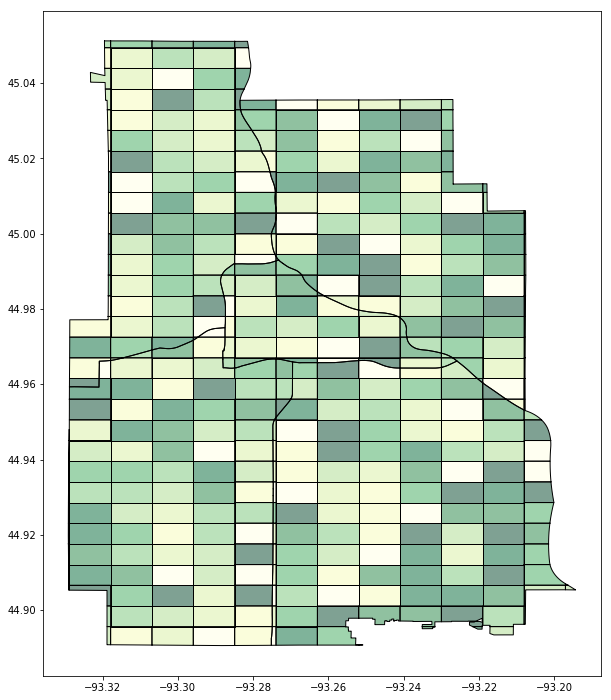

In [133]:
minplot = min_hash.plot()

In [134]:
# count number of incidents for each hash
# find centroid ofpt_rhode[0].within(geo) each hash

min_hash['centroid'] = min_hash['geometry'].centroid

In [135]:
min_hash.head()

OBJECTID PRECINCT    Shape_STAr     Shape_STLe  \
0         3        3  4.616245e+08  103520.755021   
1         5        5  3.842519e+08   89658.738146   
2         3        3  4.616245e+08  103520.755021   
3         5        5  3.842519e+08   89658.738146   
4         5        5  3.842519e+08   89658.738146   

                                            geometry  \
0  POLYGON ((-93.2746705856061 44.9304286256719, ...   
1  POLYGON ((-93.27466279182271 44.9322418571377,...   
2  POLYGON ((-93.27465513559655 44.93408203125, -...   
3  POLYGON ((-93.2746553726367 44.934120593091, -...   
4  POLYGON ((-93.31787109375 44.93408203125, -93....   

                                       centroid  
0  POINT (-93.27429644745665 44.93131985725486)  
1  POINT (-93.27978957298785 44.93133657734286)  
2  POINT (-93.27430067597831 44.93685683039057)  
3  POINT (-93.27979370964235 44.93682654719886)  
4   POINT (-93.3123779296875 44.93133544921875)

In [146]:
min_hash['num_incidents'] = np.sum(stops['geometry'].within(min_hash['geometry']))

In [154]:
def inci_num(row):
    return np.sum(stops['geometry'].within(min_hash['geometry']))

In [158]:
# inci_num(min_hash[0])

In [156]:
min_hash['num_incidents'] = min_hash.apply(lambda row: np.sum(stops['geometry'].within(row['geometry'])), axis=1)

In [157]:
min_hash.head(10)

OBJECTID PRECINCT    Shape_STAr     Shape_STLe  \
0          3        3  4.616245e+08  103520.755021   
1          5        5  3.842519e+08   89658.738146   
2          3        3  4.616245e+08  103520.755021   
..       ...      ...           ...            ...   
7          5        5  3.842519e+08   89658.738146   
8          3        3  4.616245e+08  103520.755021   
9          3        3  4.616245e+08  103520.755021   

                                             geometry  \
0   POLYGON ((-93.2746705856061 44.9304286256719, ...   
1   POLYGON ((-93.27466279182271 44.9322418571377,...   
2   POLYGON ((-93.27465513559655 44.93408203125, -...   
..                                                ...   
7   POLYGON ((-93.328857421875 44.93408203125, -93...   
8   POLYGON ((-93.22998046875 44.93408203125, -93....   
9   POLYGON ((-93.218994140625 44.93408203125, -93...   

                                        centroid  num_incidents  
0   POINT (-93.27429644745665 44.93131985725486)              5  
1   POINT (-93.27978957298785 44.93133657734286)             67  
2   POINT (-93.27430067597831 44.93685683039057)              7  
..                                           ...            ...  
7    POINT (-93.32893594851689 44.9367796257792)              0  
8    POINT (-93.2244873046875 44.93133544921875)             55  
9    POINT (-93.2244873046875 44.93682861328125)             73  

[10 rows x 7 columns]

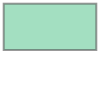

In [139]:
min_hash['geometry'][10]

In [143]:
np.sum(stops['geometry'].within(min_hash['geometry'][21]))

108

In [137]:
stops.head()

PublicAddress  ControlNbr             CCN  Precinct  \
0      8 ST S / Park AV S     3164357  MP 2013 137307         1   
1    0059XX Nicollet AV S     3164362  MP 2013 137364         5   
2  42 AV N / Aldrich AV N     3164367  MP 2013 137476         4   
3          0034XX 15 AV S     3164374  MP 2013 137472         3   
4        0009XX Lake ST E     3164389  MP 2013 137422         3   

               ReportedDate                 BeginDate      Time Offense  \
0  2013-05-05T15:05:00.000Z  2013-05-05T13:26:00.000Z  13:26:00   ASLT1   
1  2013-05-05T14:39:00.000Z  2013-05-05T14:37:00.000Z  14:37:00  SHOPLF   
2  2013-05-05T17:52:00.000Z  2013-05-04T23:00:00.000Z  23:00:00  AUTOTH   
3  2013-05-05T18:34:00.000Z  2013-05-05T16:00:00.000Z  16:00:00   THEFT   
4  2013-05-05T20:17:00.000Z  2013-05-05T15:34:00.000Z  15:34:00    TFMV   

            Description  UCRCode                  ...                    \
0  Aslt-great Bodily Hm        5                  ...                     
1           Shoplifting        7                  ...                     
2   Motor Vehicle Theft        8                  ...                     
3           Other Theft        7                  ...                     
4  Theft From Motr Vehc        7                  ...                     

     GBSID        Lat       Long             X             Y     Neighborhood  \
0      NaN  44.971890 -93.263530 -1.038205e+07  5.617096e+06      ELLIOT PARK   
1  13304.0  44.894933 -93.278106 -1.038367e+07  5.604996e+06           WINDOM   
2      NaN  45.031510 -93.289370 -1.038492e+07  5.626483e+06  WEBBER - CAMDEN   
3  11605.0  44.940454 -93.253709 -1.038096e+07  5.612152e+06  POWDERHORN PARK   
4  19104.0  44.948360 -93.260768 -1.038174e+07  5.613395e+06  POWDERHORN PARK   

                LastChanged            LastUpdateDate ESRI_OID  \
0  2013-05-07T08:53:10.000Z  2017-03-03T13:40:06.000Z     6001   
1  2013-05-06T12:31:17.000Z  2017-03-03T13:40:06.000Z     6002   
2  2013-05-06T19:20:35.000Z  2017-03-03T13:40:06.000Z     6003   
3  2013-05-07T18:03:55.000Z  2017-03-03T13:40:06.000Z     6004   
4  2013-05-06T06:36:41.000Z  2017-03-03T13:40:06.000Z     6005   

                                geometry  
0             POINT (-93.26353 44.97189)  
1  POINT (-93.27810550000001 44.8949328)  
2    POINT (-93.28936999999999 45.03151)  
3       POINT (-93.25370902 44.94045442)  
4       POINT (-93.26076768 44.94836007)  

[5 rows x 21 columns]

In [177]:
min_hash['num_incidents'].max()

805

In [191]:


min_hash['Lat'] = min_hash.apply(lambda row: row['centroid'].y, axis=1)
min_hash['Long'] = min_hash.apply(lambda row: row['centroid'].x, axis=1)

In [247]:
max_incidents = float(min_hash['num_incidents'].max())

heat_map = folium.Map(location=[44.98,-93.26], zoom_start=11, )

htmp_wide = HeatMap( zip(min_hash.Lat.values, min_hash.Long.values, min_hash.num_incidents.values), 
                   min_opacity=0.2,
                   max_val=max_incidents,
                   radius=20, blur=15, 
                   max_zoom=1, 
                 )

heat_map.add_child(htmp_wide)

## Machine Learning

Let's take data and shapefiles from another city, Oakland, CA

In [129]:
# coding: UTF-8
"""
Copyright (C) 2009 Hiroaki Kawai <kawai@iij.ad.jp>
"""
try:
	import _geohash
except ImportError:
	_geohash = None

__version__ = "0.8.5"
__all__ = ['encode','decode','decode_exactly','bbox', 'neighbors', 'expand']

_base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
_base32_map = {}
for i in range(len(_base32)):
	_base32_map[_base32[i]] = i
del i

LONG_ZERO = 0
import sys
if sys.version_info[0] < 3:
	LONG_ZERO = long(0)

def _float_hex_to_int(f):
	if f<-1.0 or f>=1.0:
		return None
	
	if f==0.0:
		return 1,1
	
	h = f.hex()
	x = h.find("0x1.")
	assert(x>=0)
	p = h.find("p")
	assert(p>0)
	
	half_len = len(h[x+4:p])*4-int(h[p+1:])
	if x==0:
		r = (1<<half_len) + ((1<<(len(h[x+4:p])*4)) + int(h[x+4:p],16))
	else:
		r = (1<<half_len) - ((1<<(len(h[x+4:p])*4)) + int(h[x+4:p],16))
	
	return r, half_len+1

def _int_to_float_hex(i, l):
	if l==0:
		return -1.0
	
	half = 1<<(l-1)
	s = int((l+3)/4)
	if i >= half:
		i = i-half
		return float.fromhex(("0x0.%0"+str(s)+"xp1") % (i<<(s*4-l),))
	else:
		i = half-i
		return float.fromhex(("-0x0.%0"+str(s)+"xp1") % (i<<(s*4-l),))

def _encode_i2c(lat,lon,lat_length,lon_length):
	precision = int((lat_length+lon_length)/5)
	if lat_length < lon_length:
		a = lon
		b = lat
	else:
		a = lat
		b = lon
	
	boost = (0,1,4,5,16,17,20,21)
	ret = ''
	for i in range(precision):
		ret+=_base32[(boost[a&7]+(boost[b&3]<<1))&0x1F]
		t = a>>3
		a = b>>2
		b = t
	
	return ret[::-1]

def encode(latitude, longitude, precision=12):
	if latitude >= 90.0 or latitude < -90.0:
		raise Exception("invalid latitude.")
	while longitude < -180.0:
		longitude += 360.0
	while longitude >= 180.0:
		longitude -= 360.0
	
	if _geohash:
		basecode=_geohash.encode(latitude,longitude)
		if len(basecode)>precision:
			return basecode[0:precision]
		return basecode+'0'*(precision-len(basecode))
	
	xprecision=precision+1
	lat_length = lon_length = int(xprecision*5/2)
	if xprecision%2==1:
		lon_length+=1
	
	if hasattr(float, "fromhex"):
		a = _float_hex_to_int(latitude/90.0)
		o = _float_hex_to_int(longitude/180.0)
		if a[1] > lat_length:
			ai = a[0]>>(a[1]-lat_length)
		else:
			ai = a[0]<<(lat_length-a[1])
		
		if o[1] > lon_length:
			oi = o[0]>>(o[1]-lon_length)
		else:
			oi = o[0]<<(lon_length-o[1])
		
		return _encode_i2c(ai, oi, lat_length, lon_length)[:precision]
	
	lat = latitude/180.0
	lon = longitude/360.0
	
	if lat>0:
		lat = int((1<<lat_length)*lat)+(1<<(lat_length-1))
	else:
		lat = (1<<lat_length-1)-int((1<<lat_length)*(-lat))
	
	if lon>0:
		lon = int((1<<lon_length)*lon)+(1<<(lon_length-1))
	else:
		lon = (1<<lon_length-1)-int((1<<lon_length)*(-lon))
	
	return _encode_i2c(lat,lon,lat_length,lon_length)[:precision]

def _decode_c2i(hashcode):
	lon = 0
	lat = 0
	bit_length = 0
	lat_length = 0
	lon_length = 0
	for i in hashcode:
		t = _base32_map[i]
		if bit_length%2==0:
			lon = lon<<3
			lat = lat<<2
			lon += (t>>2)&4
			lat += (t>>2)&2
			lon += (t>>1)&2
			lat += (t>>1)&1
			lon += t&1
			lon_length+=3
			lat_length+=2
		else:
			lon = lon<<2
			lat = lat<<3
			lat += (t>>2)&4
			lon += (t>>2)&2
			lat += (t>>1)&2
			lon += (t>>1)&1
			lat += t&1
			lon_length+=2
			lat_length+=3
		
		bit_length+=5
	
	return (lat,lon,lat_length,lon_length)

def decode(hashcode, delta=False):
	'''
	decode a hashcode and get center coordinate, and distance between center and outer border
	'''
	if _geohash:
		(lat,lon,lat_bits,lon_bits) = _geohash.decode(hashcode)
		latitude_delta = 90.0/(1<<lat_bits)
		longitude_delta = 180.0/(1<<lon_bits)
		latitude = lat + latitude_delta
		longitude = lon + longitude_delta
		if delta:
			return latitude,longitude,latitude_delta,longitude_delta
		return latitude,longitude
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	
	if hasattr(float, "fromhex"):
		latitude_delta  = 90.0/(1<<lat_length)
		longitude_delta = 180.0/(1<<lon_length)
		latitude = _int_to_float_hex(lat, lat_length) * 90.0 + latitude_delta
		longitude = _int_to_float_hex(lon, lon_length) * 180.0 + longitude_delta
		if delta:
			return latitude,longitude,latitude_delta,longitude_delta
		return latitude,longitude
	
	lat = (lat<<1) + 1
	lon = (lon<<1) + 1
	lat_length += 1
	lon_length += 1
	
	latitude  = 180.0*(lat-(1<<(lat_length-1)))/(1<<lat_length)
	longitude = 360.0*(lon-(1<<(lon_length-1)))/(1<<lon_length)
	if delta:
		latitude_delta  = 180.0/(1<<lat_length)
		longitude_delta = 360.0/(1<<lon_length)
		return latitude,longitude,latitude_delta,longitude_delta
	
	return latitude,longitude

def decode_exactly(hashcode):
	return decode(hashcode, True)

## hashcode operations below

def bbox(hashcode):
	'''
	decode a hashcode and get north, south, east and west border.
	'''
	if _geohash:
		(lat,lon,lat_bits,lon_bits) = _geohash.decode(hashcode)
		latitude_delta = 180.0/(1<<lat_bits)
		longitude_delta = 360.0/(1<<lon_bits)
		return {'s':lat,'w':lon,'n':lat+latitude_delta,'e':lon+longitude_delta}
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	if hasattr(float, "fromhex"):
		latitude_delta  = 180.0/(1<<lat_length)
		longitude_delta = 360.0/(1<<lon_length)
		latitude = _int_to_float_hex(lat, lat_length) * 90.0
		longitude = _int_to_float_hex(lon, lon_length) * 180.0
		return {"s":latitude, "w":longitude, "n":latitude+latitude_delta, "e":longitude+longitude_delta}
	
	ret={}
	if lat_length:
		ret['n'] = 180.0*(lat+1-(1<<(lat_length-1)))/(1<<lat_length)
		ret['s'] = 180.0*(lat-(1<<(lat_length-1)))/(1<<lat_length)
	else: # can't calculate the half with bit shifts (negative shift)
		ret['n'] = 90.0
		ret['s'] = -90.0
	
	if lon_length:
		ret['e'] = 360.0*(lon+1-(1<<(lon_length-1)))/(1<<lon_length)
		ret['w'] = 360.0*(lon-(1<<(lon_length-1)))/(1<<lon_length)
	else: # can't calculate the half with bit shifts (negative shift)
		ret['e'] = 180.0
		ret['w'] = -180.0
	
	return ret

def neighbors(hashcode):
	if _geohash and len(hashcode)<25:
		return _geohash.neighbors(hashcode)
	
	(lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
	ret = []
	tlat = lat
	for tlon in (lon-1, lon+1):
		code = _encode_i2c(tlat,tlon,lat_length,lon_length)
		if code:
			ret.append(code)
	
	tlat = lat+1
	if not tlat >> lat_length:
		for tlon in (lon-1, lon, lon+1):
			ret.append(_encode_i2c(tlat,tlon,lat_length,lon_length))
	
	tlat = lat-1
	if tlat >= 0:
		for tlon in (lon-1, lon, lon+1):
			ret.append(_encode_i2c(tlat,tlon,lat_length,lon_length))
	
	return ret

def expand(hashcode):
	ret = neighbors(hashcode)
	ret.append(hashcode)
	return ret

def _uint64_interleave(lat32, lon32):
	intr = 0
	boost = (0,1,4,5,16,17,20,21,64,65,68,69,80,81,84,85)
	for i in range(8):
		intr = (intr<<8) + (boost[(lon32>>(28-i*4))%16]<<1) + boost[(lat32>>(28-i*4))%16]
	
	return intr

def _uint64_deinterleave(ui64):
	lat = lon = 0
	boost = ((0,0),(0,1),(1,0),(1,1),(0,2),(0,3),(1,2),(1,3),
			 (2,0),(2,1),(3,0),(3,1),(2,2),(2,3),(3,2),(3,3))
	for i in range(16):
		p = boost[(ui64>>(60-i*4))%16]
		lon = (lon<<2) + p[0]
		lat = (lat<<2) + p[1]
	
	return (lat, lon)

def encode_uint64(latitude, longitude):
	if latitude >= 90.0 or latitude < -90.0:
		raise ValueError("Latitude must be in the range of (-90.0, 90.0)")
	while longitude < -180.0:
		longitude += 360.0
	while longitude >= 180.0:
		longitude -= 360.0
	
	if _geohash:
		ui128 = _geohash.encode_int(latitude,longitude)
		if _geohash.intunit == 64:
			return ui128[0]
		elif _geohash.intunit == 32:
			return (ui128[0]<<32) + ui128[1]
		elif _geohash.intunit == 16:
			return (ui128[0]<<48) + (ui128[1]<<32) + (ui128[2]<<16) + ui128[3]
	
	lat = int(((latitude + 90.0)/180.0)*(1<<32))
	lon = int(((longitude+180.0)/360.0)*(1<<32))
	return _uint64_interleave(lat, lon)

def decode_uint64(ui64):
	if _geohash:
		latlon = _geohash.decode_int(ui64 % 0xFFFFFFFFFFFFFFFF, LONG_ZERO)
		if latlon:
			return latlon
	
	lat,lon = _uint64_deinterleave(ui64)
	return (180.0*lat/(1<<32) - 90.0, 360.0*lon/(1<<32) - 180.0)

def expand_uint64(ui64, precision=50):
	ui64 = ui64 & (0xFFFFFFFFFFFFFFFF << (64-precision))
	lat,lon = _uint64_deinterleave(ui64)
	lat_grid = 1<<(32-int(precision/2))
	lon_grid = lat_grid>>(precision%2)
	
	if precision<=2: # expand becomes to the whole range
		return []
	
	ranges = []
	if lat & lat_grid:
		if lon & lon_grid:
			ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (1, 1) and even precision
				ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (1, 1) and odd precision
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
		else:
			ui64 = _uint64_interleave(lat-lat_grid, lon)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (1, 0) and odd precision
				ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (1, 0) and odd precision
				if lat + lat_grid < 0xFFFFFFFF:
					ui64 = _uint64_interleave(lat+lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
	else:
		if lon & lon_grid:
			ui64 = _uint64_interleave(lat, lon-lon_grid)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (0, 1) and even precision
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (0, 1) and odd precision
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat+lat_grid, lon+lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
		else:
			ui64 = _uint64_interleave(lat, lon)
			ranges.append((ui64, ui64 + (1<<(64-precision+2))))
			if precision%2==0:
				# lat,lon = (0, 0) and even precision
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision+1))))
				
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
					ui64 = _uint64_interleave(lat-lat_grid, lon+lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
			else:
				# lat,lon = (0, 0) and odd precision
				if lat > 0:
					ui64 = _uint64_interleave(lat-lat_grid, lon)
					ranges.append((ui64, ui64 + (1<<(64-precision+1))))
					
					ui64 = _uint64_interleave(lat-lat_grid, lon-lon_grid)
					ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
				ui64 = _uint64_interleave(lat+lat_grid, lon-lon_grid)
				ranges.append((ui64, ui64 + (1<<(64-precision))))
	
	ranges.sort()
	
	# merge the conditions
	shrink = []
	prev = None
	for i in ranges:
		if prev:
			if prev[1] != i[0]:
				shrink.append(prev)
				prev = i
			else:
				prev = (prev[0], i[1])
		else:
			prev = i
	
	shrink.append(prev)
	
	ranges = []
	for i in shrink:
		a,b=i
		if a == 0:
			a = None # we can remove the condition because it is the lowest value
		if b == 0x10000000000000000:
			b = None # we can remove the condition because it is the highest value
		
		ranges.append((a,b))
	
	return ranges